## Desafio Técnico Dhauz
## Análise de Sentimento utilizando Processamento de Linguagem Natural Clássica
### Data:13/09/2024
#### Autor: Felipe Pinto Marinho

#### Carregando pacotes relevantes para a tarefa em análise

In [63]:
#Pacotes requerido para a tarefa em análise
import json
import pandas as pd
from tqdm import tqdm
import numpy as np

#Visualização gráfica
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#Modelagem
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#XGBoost
from xgboost import XGBClassifier
from xgboost import plot_importance

#Processamento de Linguagem Natural
from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#warnings
import warnings

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [6]:
warnings.filterwarnings('ignore')

#### Carregando a base de dados para a modelagem

In [9]:
df = pd.read_csv('Travel_Chalenge.csv', sep=';')
df.head(5)

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,Air Seychelles,8,Air Seychelles customer review,10th April 2011,LHR-SEZ-LHR. It's true that there aren't perso...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CityJet,1,CityJet customer review,10th April 2011,London City to Antwerp was delayed 3 hours 40 ...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Shanghai Airlines,9,Shanghai Airlines customer review,10th April 2012,PEK to HGH in Economy. Slight delay out of PEK...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,4.0,NaN,2.0,NaN
3,Aerolineas Argentinas,8,Aerolineas Argentinas customer review,10th April 2014,Rio to Buenos Aires AEP on 737. Departure dela...,NaN,NaN,Economy Class,NaN,NaN,3.0,4.0,0.0,NaN,0.0,NaN
4,Adria Airways,7,Adria Airways customer review,10th April 2015,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy Class,NaN,NaN,4.0,4.0,4.0,NaN,0.0,NaN


#### Realizando uma Análise Exploratória dos Dados (EDA)

In [10]:
#Avaliação inicial do dataset
print(df.shape)
df.info()

(17702, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17702 entries, 0 to 17701
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Name            17702 non-null  object 
 1   Overall_Rating          17702 non-null  object 
 2   Review_Title            17702 non-null  object 
 3   Review Date             17702 non-null  object 
 4   Review                  17702 non-null  object 
 5   Aircraft                5665 non-null   object 
 6   Type Of Traveller       15953 non-null  object 
 7   Seat Type               17461 non-null  object 
 8   Route                   15876 non-null  object 
 9   Date Flown              15944 non-null  object 
 10  Seat Comfort            15456 non-null  float64
 11  Cabin Staff Service     15366 non-null  float64
 12  Food & Beverages        11924 non-null  float64
 13  Ground Service          15056 non-null  float64
 14  Inflight Entertainment  92

In [11]:
#Analisando o percentual de nulos
df.isna().sum()/df.shape[0]

Airline Name              0.000000
Overall_Rating            0.000000
Review_Title              0.000000
Review Date               0.000000
Review                    0.000000
Aircraft                  0.679980
Type Of Traveller         0.098802
Seat Type                 0.013614
Route                     0.103152
Date Flown                0.099311
Seat Comfort              0.126878
Cabin Staff Service       0.131962
Food & Beverages          0.326404
Ground Service            0.149475
Inflight Entertainment    0.478533
Wifi & Connectivity       0.703819
dtype: float64

In [12]:
#Avaliando apenas as colunas numéricas do dataset
df.select_dtypes(include = np.number)

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,4.0,4.0,NaN,2.0,NaN
3,3.0,4.0,0.0,NaN,0.0,NaN
4,4.0,4.0,4.0,NaN,0.0,NaN
...,...,...,...,...,...,...
17697,1.0,1.0,NaN,1.0,NaN,NaN
17698,2.0,2.0,1.0,1.0,NaN,NaN
17699,1.0,1.0,1.0,1.0,1.0,1.0
17700,3.0,4.0,NaN,4.0,NaN,NaN


In [13]:
#Tratando com os valores nulo por meio de imputação para as colunas numéricas e
#por subsitituição por mais frequente  em colunas categóricas
#Colunas numéricas
imp = SimpleImputer(missing_values = np.nan, strategy = "median")
imp.fit(df.select_dtypes(include = np.number))
df_numericals_without_nan = pd.DataFrame(imp.transform(df.select_dtypes(include = np.number)),
                                         columns = list(df.select_dtypes(include = np.number).columns))
df_numericals_without_nan.head(3)

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,3.0,3.0,2.0,1.0,2.0,1.0
1,3.0,3.0,2.0,1.0,2.0,1.0
2,3.0,4.0,4.0,1.0,2.0,1.0


In [14]:
#Analisando as colunas não númericas
df.select_dtypes(include = object).head(3)

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown
0,Air Seychelles,8,Air Seychelles customer review,10th April 2011,LHR-SEZ-LHR. It's true that there aren't perso...,NaN,NaN,Economy Class,NaN,NaN
1,CityJet,1,CityJet customer review,10th April 2011,London City to Antwerp was delayed 3 hours 40 ...,NaN,NaN,Economy Class,NaN,NaN
2,Shanghai Airlines,9,Shanghai Airlines customer review,10th April 2012,PEK to HGH in Economy. Slight delay out of PEK...,NaN,NaN,Economy Class,NaN,NaN


In [15]:
#### Tratando os valores nulos nas colunas não numéricas pela imputação por zero
#### Assim tais valores não impactarão na capacidade discriminativa do classficador
#### nem se perderá uma grande quantidade de linhas do dataset
df_categoricals_whitout_nan = df.select_dtypes(include = object).fillna(0)
df_categoricals_whitout_nan.head(3)

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown
0,Air Seychelles,8,Air Seychelles customer review,10th April 2011,LHR-SEZ-LHR. It's true that there aren't perso...,0,0,Economy Class,0,0
1,CityJet,1,CityJet customer review,10th April 2011,London City to Antwerp was delayed 3 hours 40 ...,0,0,Economy Class,0,0
2,Shanghai Airlines,9,Shanghai Airlines customer review,10th April 2012,PEK to HGH in Economy. Slight delay out of PEK...,0,0,Economy Class,0,0


In [16]:
#Concatenando as colunas tratadas
df_without_nan = pd.concat([df_categoricals_whitout_nan,
                            df_numericals_without_nan], axis = 1)
df_without_nan.head(3)

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,Air Seychelles,8,Air Seychelles customer review,10th April 2011,LHR-SEZ-LHR. It's true that there aren't perso...,0,0,Economy Class,0,0,3.0,3.0,2.0,1.0,2.0,1.0
1,CityJet,1,CityJet customer review,10th April 2011,London City to Antwerp was delayed 3 hours 40 ...,0,0,Economy Class,0,0,3.0,3.0,2.0,1.0,2.0,1.0
2,Shanghai Airlines,9,Shanghai Airlines customer review,10th April 2012,PEK to HGH in Economy. Slight delay out of PEK...,0,0,Economy Class,0,0,3.0,4.0,4.0,1.0,2.0,1.0


In [17]:
#Analisando alguns atributos
features_analysis = ['Review', 'Review_Title']
for i in features_analysis:
    print(df[i].head(5))

0    LHR-SEZ-LHR. It's true that there aren't perso...
1    London City to Antwerp was delayed 3 hours 40 ...
2    PEK to HGH in Economy. Slight delay out of PEK...
3    Rio to Buenos Aires AEP on 737. Departure dela...
4    Outbound flight FRA/PRN A319. 2 hours 10 min f...
Name: Review, dtype: object
0           Air Seychelles customer review
1                  CityJet customer review
2        Shanghai Airlines customer review
3    Aerolineas Argentinas customer review
4            Adria Airways customer review
Name: Review_Title, dtype: object


#### Realizando procedimentos pré-processamento padrões processamento de linguagem natural para os atributos *Review* e *Review_Title*

In [18]:
def preprocess_text(text):
    '''
    Criando uma função para realizar o pré-processamento do texto
    na qual primeiro tokenizamos os documentos, depois removemos 
    palavras irrelevantes e, por fim, lematizamos
    '''

    #Tokenizando o texto
    tokens = word_tokenize(text.lower())

    #Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    #Lematização
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    #Juntando os tokens resultantes em uma string
    processed_text = ''.join(lemmatized_tokens)

    return processed_text

#Aplicando a função nas colunas Review e Review_Title
df_without_nan['Review'] = df['Review'].apply(preprocess_text)
df_without_nan['Review_Title'] = df['Review_Title'].apply(preprocess_text)
df_without_nan.head(5)

,Airline Name,Overall_Rating,Review_Title,Review Date,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
0,Air Seychelles,8,airseychellescustomerreview,10th April 2011,lhr-sez-lhr.'struen'tpersonaltvlikevirginban't...,0,0,Economy Class,0,0,3.0,3.0,2.0,1.0,2.0,1.0
1,CityJet,1,cityjetcustomerreview,10th April 2011,londoncityantwerpdelayed3hour40minsurewhether'...,0,0,Economy Class,0,0,3.0,3.0,2.0,1.0,2.0,1.0
2,Shanghai Airlines,9,shanghaiairlinecustomerreview,10th April 2012,pekhgheconomy.slightdelaypekotherwiseuneventfu...,0,0,Economy Class,0,0,3.0,4.0,4.0,1.0,2.0,1.0
3,Aerolineas Argentinas,8,aerolineasargentinacustomerreview,10th April 2014,riobuenosaireaep737.departuredelayed30minarriv...,0,0,Economy Class,0,0,3.0,4.0,0.0,1.0,0.0,1.0
4,Adria Airways,7,adriaairwaycustomerreview,10th April 2015,outboundflightfra/prna319.2hour10minflight.tho...,0,0,Economy Class,0,0,4.0,4.0,4.0,1.0,0.0,1.0


In [19]:
#Avaliando o percentual de linhas com string 'n' na coluna Overral Rating
df_without_nan['Overall_Rating'].value_counts()/df_without_nan.shape[0]

#Pelo pequeno percentual, a melhor alternativa será remover os registros com essa string
df_without_nan.drop(df_without_nan[df_without_nan.Overall_Rating == 'n'].index, inplace = True)

#### Gráficos de distribuições para os atributos *Overall_rating* e *Aircraft*


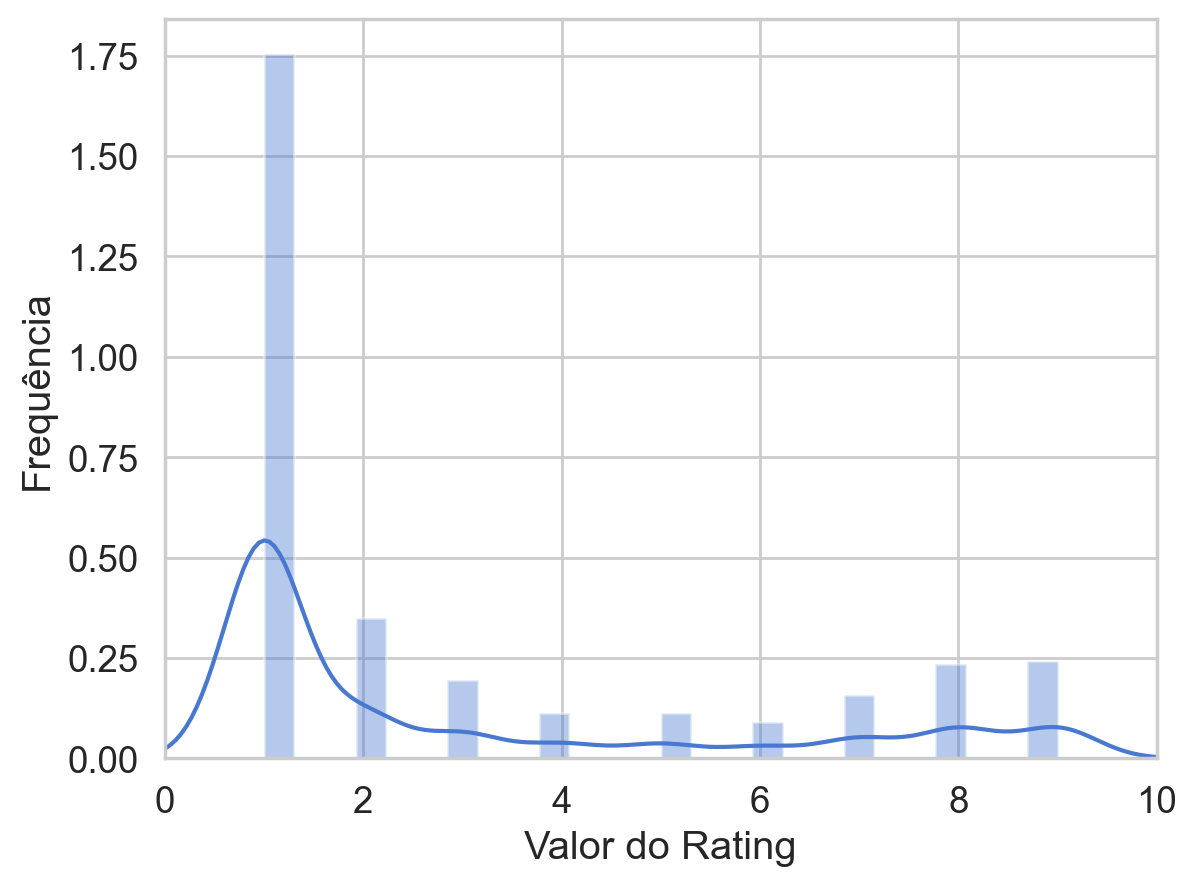

In [20]:
#Gráfico de distribuição para o atributo Overall_rating
sns.distplot(df_without_nan['Overall_Rating'])
plt.xlim([0, 10]);
plt.xlabel('Valor do Rating');
plt.ylabel('Frequência');

<AxesSubplot: >

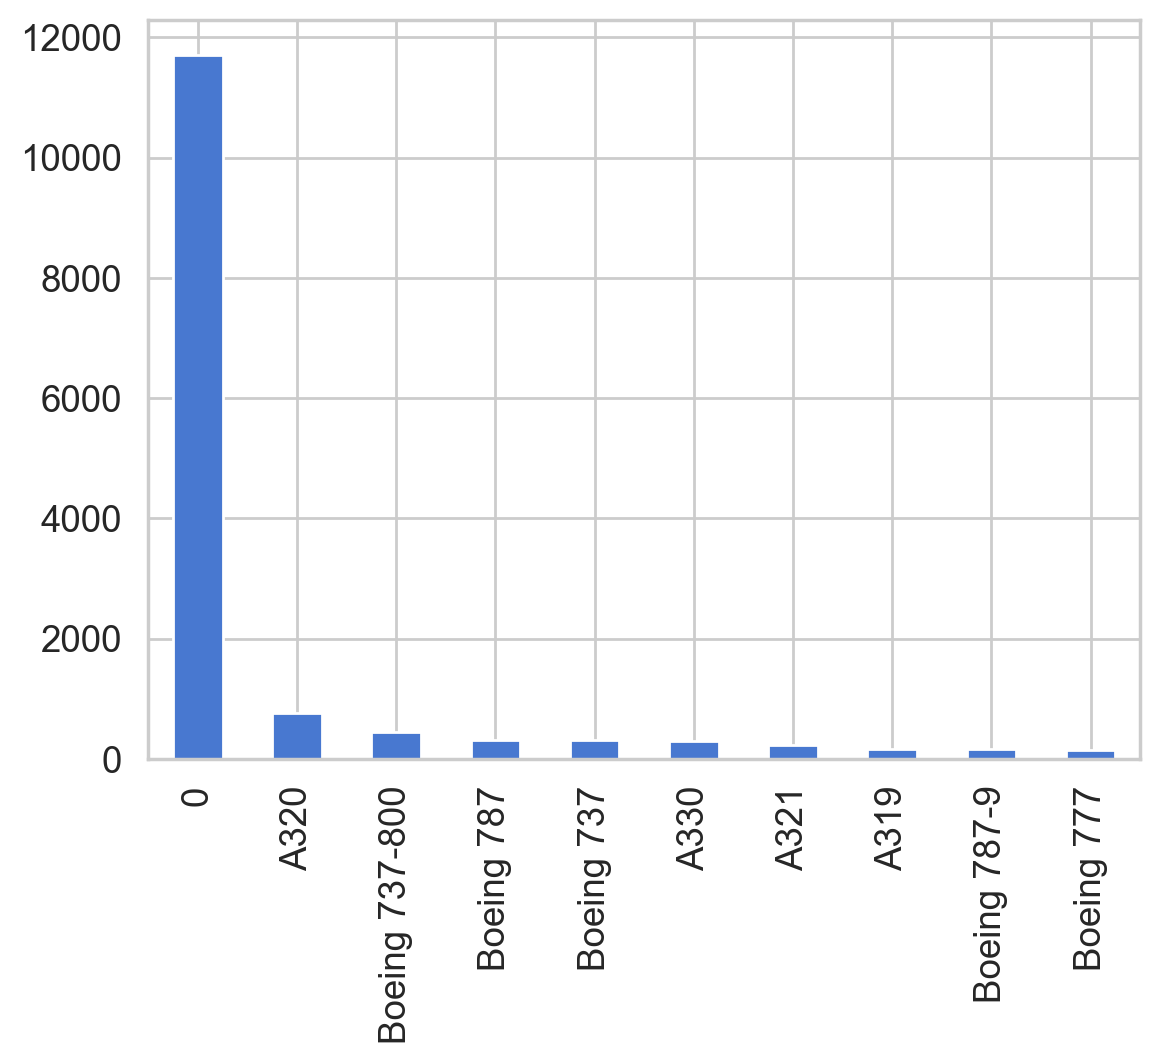

In [21]:
#Gráfico de distribuição para o atributo Aircraft
df_without_nan.Aircraft.value_counts()[:10].plot(kind = 'bar')

#### Nuvem de palavras para o atributo *Review* considerando o *Overral Rating*

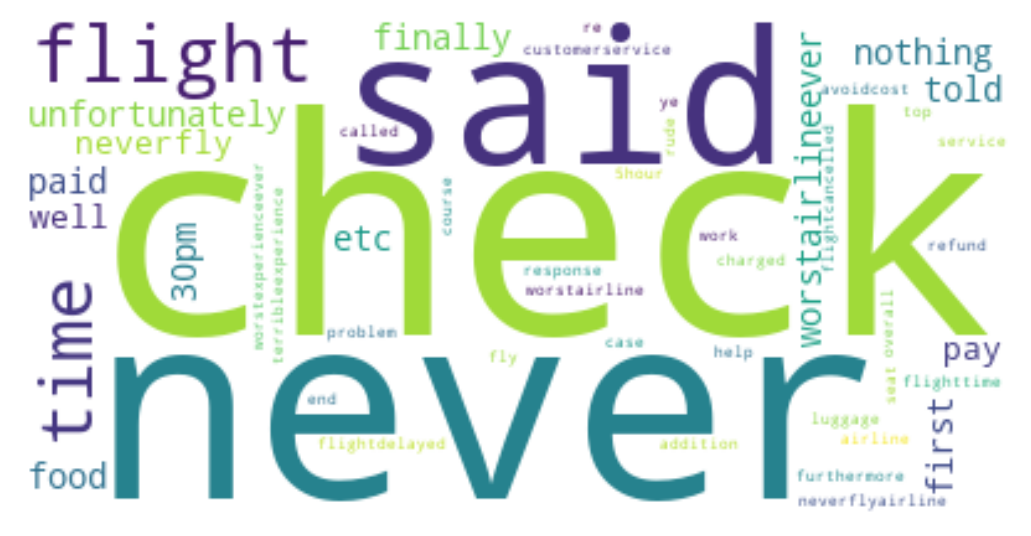

In [22]:
#Criando um dicionário de frequências cosiderando o filtro para overral rating <= 3
text = "".join(review for review in df_without_nan[df_without_nan.Overall_Rating <= '3'].Review)

#Criando e gerando uma imagem de nuvem de palavras
wordcloud = WordCloud(max_words=50, background_color="white").generate(text)

#Visualizando a nuvem de palavras
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

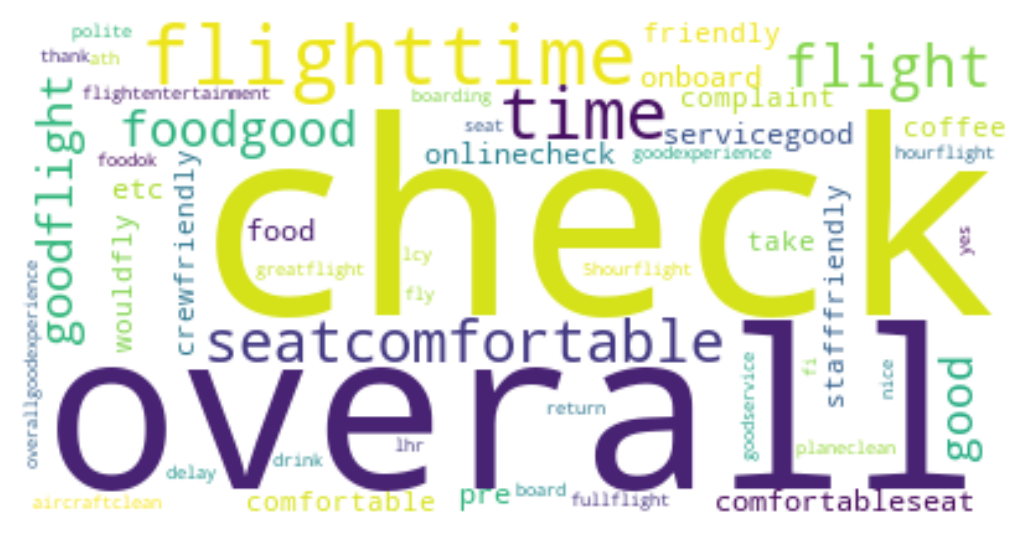

In [23]:
#Criando um dicionário de frequências cosiderando o filtro para overral rating <= 8
text = "".join(review for review in df_without_nan[df_without_nan.Overall_Rating >= '8'].Review)

#Criando e gerando uma imagem de nuvem de palavras
wordcloud = WordCloud(max_words=50, background_color="white").generate(text)

#Visualizando a nuvem de palavras
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Avaliando a correlação de spearman dos atributos numéricos da base de modelagem

In [24]:
#Convertendo a coluna Overral Rating para float
df_without_nan.Overall_Rating.astype(float).isna().sum()

0

In [25]:
#Inserindo a nova coluna no dataset de atributos numéricos
df_numericals_without_nan.insert(0, "Overral_Rating",
          df_without_nan.Overall_Rating.astype(float), True)

In [26]:
df_numericals_without_nan.corr(method = 'spearman')

,Overral_Rating,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity
Overral_Rating,1.000000,0.390748,0.415700,0.345763,0.422825,0.228094,0.090041
Seat Comfort,0.390748,1.000000,0.741398,0.621425,0.556827,0.480745,0.207921
Cabin Staff Service,0.415700,0.741398,1.000000,0.676911,0.592646,0.460895,0.204703
Food & Beverages,0.345763,0.621425,0.676911,1.000000,0.507188,0.566168,0.232619
Ground Service,0.422825,0.556827,0.592646,0.507188,1.000000,0.389584,0.235669
Inflight Entertainment,0.228094,0.480745,0.460895,0.566168,0.389584,1.000000,0.316849
Wifi & Connectivity,0.090041,0.207921,0.204703,0.232619,0.235669,0.316849,1.000000


<AxesSubplot: >

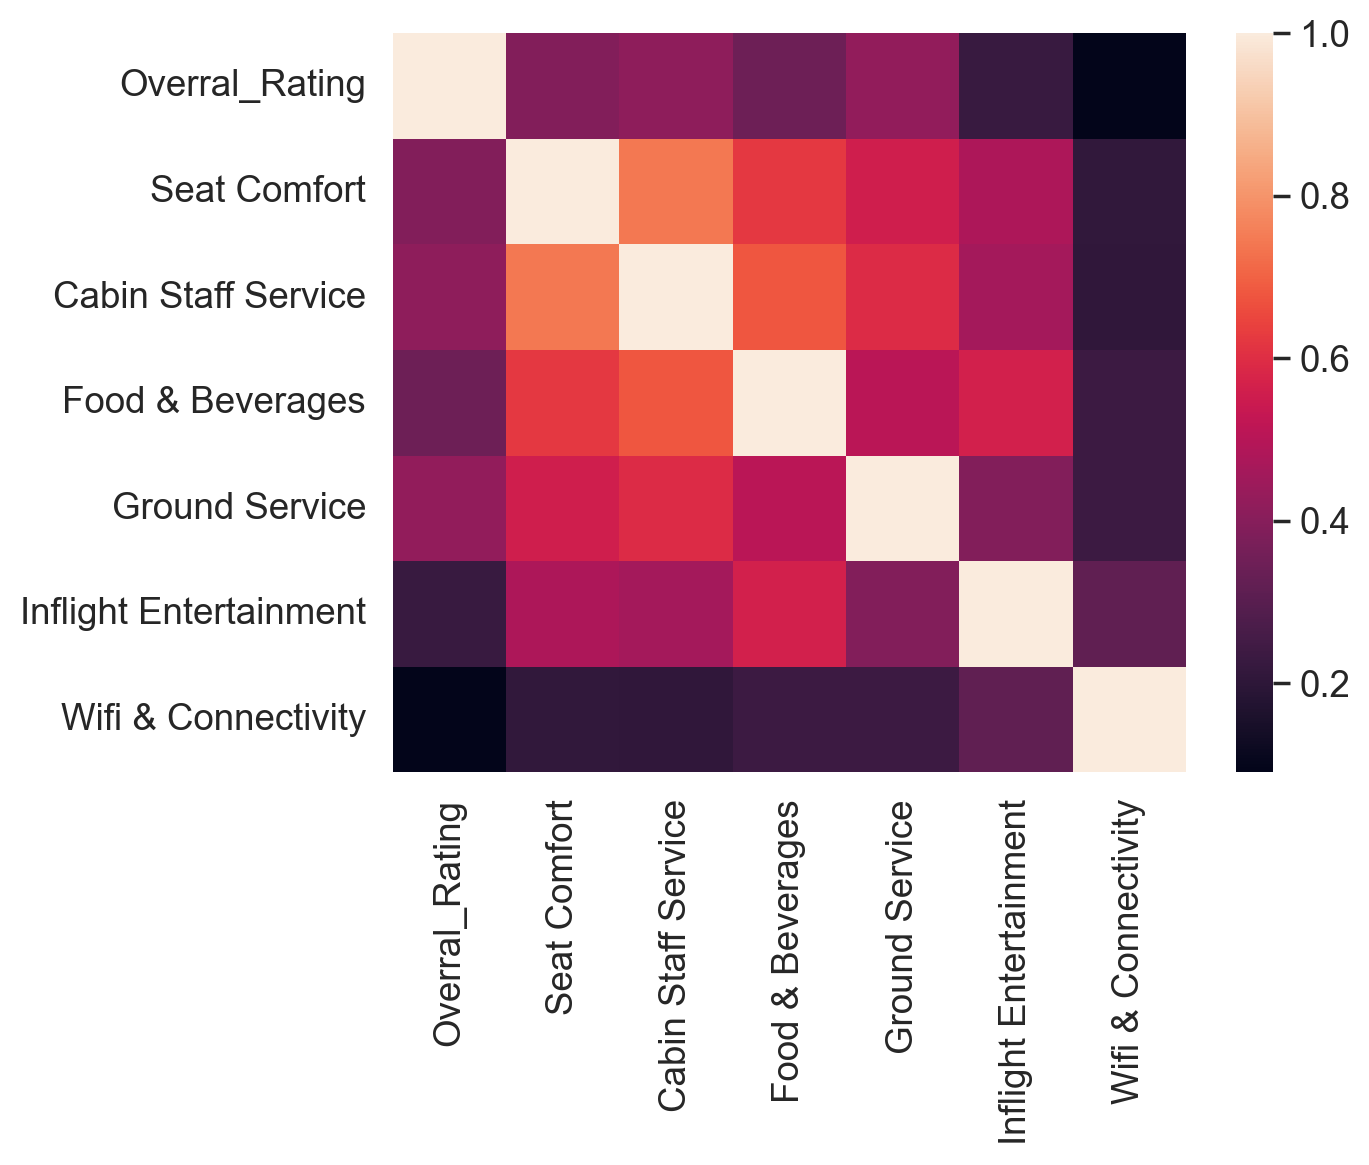

In [27]:
#Gerando a matriz de correlação de spearmen
sns.heatmap(df_numericals_without_nan.corr(method = 'spearman'))

#### Nota-se uma baixa correlação de spearmen entre os atributos númericos e a coluna *Overral Rating*

#### Modelagem (Modelo I) utilizando somente as colunas *Review* e *Review_Title*

In [68]:
df.drop(df[df.Overall_Rating == 'n'].index, inplace = True)

In [69]:
#Derivação da variável alvo
def to_sentiment(rating):
  rating = int(rating)
  if rating <4:
    return 0
  elif 4 <= rating and rating <= 7:
    return 1
  else:
    return 2

df_modelling_one = df[['Review', 'Review_Title', 'Overall_Rating']]
df_modelling_one['sentiment'] = df.Overall_Rating.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
df_modelling_one.head(3)

,Review,Review_Title,Overall_Rating,sentiment
0,LHR-SEZ-LHR. It's true that there aren't perso...,Air Seychelles customer review,8,2
1,London City to Antwerp was delayed 3 hours 40 ...,CityJet customer review,1,0
2,PEK to HGH in Economy. Slight delay out of PEK...,Shanghai Airlines customer review,9,2


#### Neste ponto, destaca-se que o *dataset* contendo somente as informações textuais será exportado em formato csv, para ser utilizado para o *fine-tunig* de um modelo BERT pré-treinado, como observado no *jupyter* intitulado BERT presente no Git

In [70]:
#Exportando o arquivo csv para utilizar em uma arquitetura BERT pré-treinada
df_modelling_one.to_csv('Reviews.csv', sep = ',')

#### Segunda abordagem utilizando apenas os atributos numéricos

In [36]:
df_modelling_two = df_numericals_without_nan.drop(columns=['Overral_Rating'], axis = 1)
df_modelling_two['sentiment'] = df_without_nan.Overall_Rating.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
df_modelling_two.head(3)

,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,sentiment
0,3.0,3.0,2.0,1.0,2.0,1.0,2.0
1,3.0,3.0,2.0,1.0,2.0,1.0,0.0
2,3.0,4.0,4.0,1.0,2.0,1.0,2.0


In [37]:
#Verificando a existência de nulos na derivação da variável de saída
df_modelling_two.isna().sum()

Seat Comfort                0
Cabin Staff Service         0
Food & Beverages            0
Ground Service              0
Inflight Entertainment      0
Wifi & Connectivity         0
sentiment                 332
dtype: int64

In [38]:
#Retirada dos registros nulos
df_modelling_two = df_modelling_two.dropna()

In [39]:
#Realizando a divisão Treino/Teste
X_train, X_test, y_train, y_test = train_test_split(df_modelling_two.drop(columns = ['sentiment']),
                                                     df_modelling_two.sentiment, test_size=0.25, random_state=42)

In [40]:
X_train.shape

(13027, 6)

In [41]:
models = {
    'RF': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(),
    'SVC': SVC(),
}

#Treinando os modelos e obtendo previsões
train_forecasts, test_forecasts = {}, {}
for k in models:
    models[k].fit(X_train, y_train)
    train_forecasts[k] = models[k].predict(X_train)
    test_forecasts[k] = models[k].predict(X_test)

#### Avaliando os desempenhos dos modelos de aprendizagem de máquina utilizados


In [42]:
#KNN
print(classification_report(y_test, test_forecasts['KNN']))

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      3039
         1.0       0.53      0.33      0.41       668
         2.0       0.54      0.42      0.48       636

    accuracy                           0.76      4343
   macro avg       0.63      0.56      0.58      4343
weighted avg       0.74      0.76      0.74      4343



In [43]:
#CART
print(classification_report(y_test, test_forecasts['CART']))

              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      3039
         1.0       0.53      0.33      0.40       668
         2.0       0.55      0.53      0.54       636

    accuracy                           0.77      4343
   macro avg       0.64      0.59      0.61      4343
weighted avg       0.75      0.77      0.75      4343



In [44]:
#Random Forest
print(classification_report(y_test, test_forecasts['RF']))

              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      3039
         1.0       0.57      0.35      0.44       668
         2.0       0.55      0.57      0.56       636

    accuracy                           0.78      4343
   macro avg       0.65      0.61      0.63      4343
weighted avg       0.76      0.78      0.76      4343



In [45]:
#Máquina de Vetor de Suporte
print(classification_report(y_test, test_forecasts['SVC']))

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88      3039
         1.0       0.63      0.30      0.40       668
         2.0       0.58      0.61      0.60       636

    accuracy                           0.78      4343
   macro avg       0.68      0.61      0.62      4343
weighted avg       0.77      0.78      0.76      4343



#### Nota-se um empate técnico entre os classificadores SVC e RF, com base em parsimônia e menor risco de *Overfitting*, seleciona-se o classificador SVC para a fase de *tunig* de hiperparâmetros

In [66]:
#Treinando os modelos utilizando validação cruzada
#5 Folds no conjunto de treino
scoring_classification = {'Acurácia': 'accuracy'}

param_grid_SVC = {'C': [1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']}

gs_SVC = GridSearchCV(SVC(), param_grid_SVC, refit = True, verbose = 3)

gs_SVC.fit(X_train, y_train)
results_SVR = gs_SVC.cv_results_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.773 total time=   5.2s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.784 total time=   6.2s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.775 total time=   5.6s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.786 total time=   5.5s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.770 total time=   5.4s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.790 total time=   5.3s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.787 total time=   5.2s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.781 total time=   4.8s
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.788 total time=   4.9s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.781 total time=   4.8s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.762 total time=   5.1s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;

In [72]:
#Melhores parâmetros
print(gs_SVC.best_params_) 
  
#Modelo ótimo 
print(gs_SVC.best_estimator_) 

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


#### Avaliação utilizando o modelo SVC otimizado

In [73]:
#Obtendo predições com o modelo ótimo
grid_predictions = gs_SVC.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88      3039
         1.0       0.63      0.30      0.41       668
         2.0       0.58      0.61      0.59       636

    accuracy                           0.78      4343
   macro avg       0.68      0.61      0.63      4343
weighted avg       0.77      0.78      0.76      4343

